In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from plotting_fxns import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


This notebook is intended to make plotting of the PyGEM-EB output straightforward for fast diagnostics after a model run. Most functions just need the information for the model run in the cell below. 

Specify the plotting style to use and the figure name to save the plot.

Run the following cells to plot the data. For information on any of the plotting functions, run 'help(name_of_function)'. Available functions are:
- simple_plot
- plot_AWS
- plot_stake_data
- compare_runs
- stacked_eb_barplot

In [6]:
# Load in the data and get the dates available for the model run
output_fn = '~/research/Output/EB/Gulkana_2024_01_25_0.nc' 
ds,startdate,enddate = getds(output_fn)
bin = 0
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23.csv')
temp_df = pd.read_csv('~/research/MB_data/Gulkana/field_data/iButton_2023_all.csv')

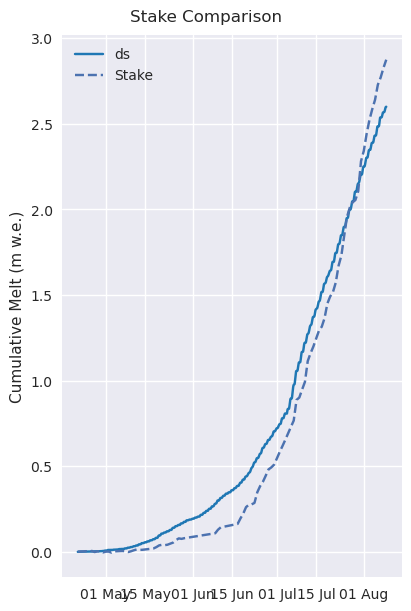

In [9]:
plot_stake_ablation(stake_df,[ds],[startdate,enddate],['ds'])

In [ ]:
# ds3,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2023_12_11_3.nc' )
# ds3,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2023_12_12_0.nc' )
ds0,startdate,enddate = getds('/home/claire/research/Output/EB/Gulkana_2024_01_10_0.nc' )
ds1,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_01_10_1.nc' )
ds2,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_01_10_2.nc' )
ds3,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_01_10_3.nc' )
ds4,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_01_10_4.nc' )
ds5,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_01_10_5.nc' )
ds6,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_01_10_6.nc' )
# ds7,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2023_12_23_7.nc' )

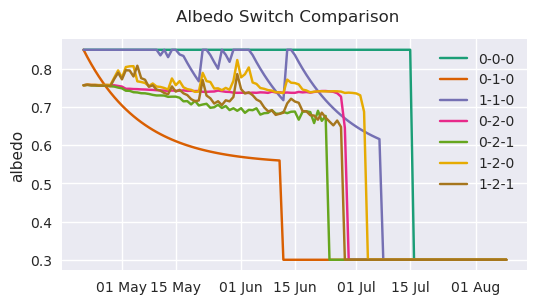

In [ ]:
switch_labels = ['0-0-0','0-1-0','1-1-0','0-2-0','0-2-1','1-2-0','1-2-1']
ds_list = [ds0,ds1,ds2,ds3,ds4,ds5,ds6]
idx = slice(0,7,1)
compare_runs(ds_list[idx],[startdate,enddate],switch_labels[idx],'albedo',t='Albedo Switch Comparison')

In [14]:
param_options = {
          'lapserate':{'options':[-0.003,-0.01],'value':-0.0065,'units':'K/m'},
          'tsnow_threshold':{'options':[0,2],'value':0,'units':'C'},
          'precgrad':{'options':[5e-6,5e-4],'value':0.0001,'units':''},
          'kp':{'options':[0.5,5],'value':1,'units':''},
          'albedo_ice':{'options':[0.2,0.4],'value':0.3,'units':''},
          'roughness_ice':{'options':[0.5,3],'value':1.7,'units':'mm'},
          'k_ice':{'options':[1.5,3],'value':2.33,'units':'W/K '},
          'ksp_BC':{'options':[0.01,0.8],'value':0.1,'units':'kg/kg'},
          'ksp_dust':{'options':[0.001,0.08],'value':0.015,'units':'kg/kg'},
          'dz_toplayer':{'options':[0.01,0.05],'value':0.03,'units':'m'},
          'layer_growth':{'options':[0.6,0.9],'value':0.6,'units':''},
          'fresh_grainsize':{'options':[30,100],'value':54.5,'units':'um'},
          'aging_factor_roughness':{'options':[0.04,0.08],'value':0.06267,'units':'mm/d'},
          'albedo_TOD':{'options':[8,16],'value':0,'units':'hrs'},
          'initSSA':{'options':[60,100],'value':80,'units':'m^2/kg'},
          'dry_metamorphism_rate':{'options':[1e-5,6e-5],'value':3.5e-5,'units':'um/s'}
          }
filename = '/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_25_VAR_VALUE.nc'

ds_dict = {}
for key in list(param_options.keys()):
    for value in param_options[key]['options']:
        fn = filename.replace('VAR',key).replace('VALUE',str(value))
        ds,startdate,enddate = getds(fn)
        ds_dict[key+'='+str(value)] = ds

# ds,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_0.nc')
# ds_dict['LAPbins=yes'] = ds
# ds,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_noLAPbins.nc')
# ds_dict['LAPbins=no'] = ds

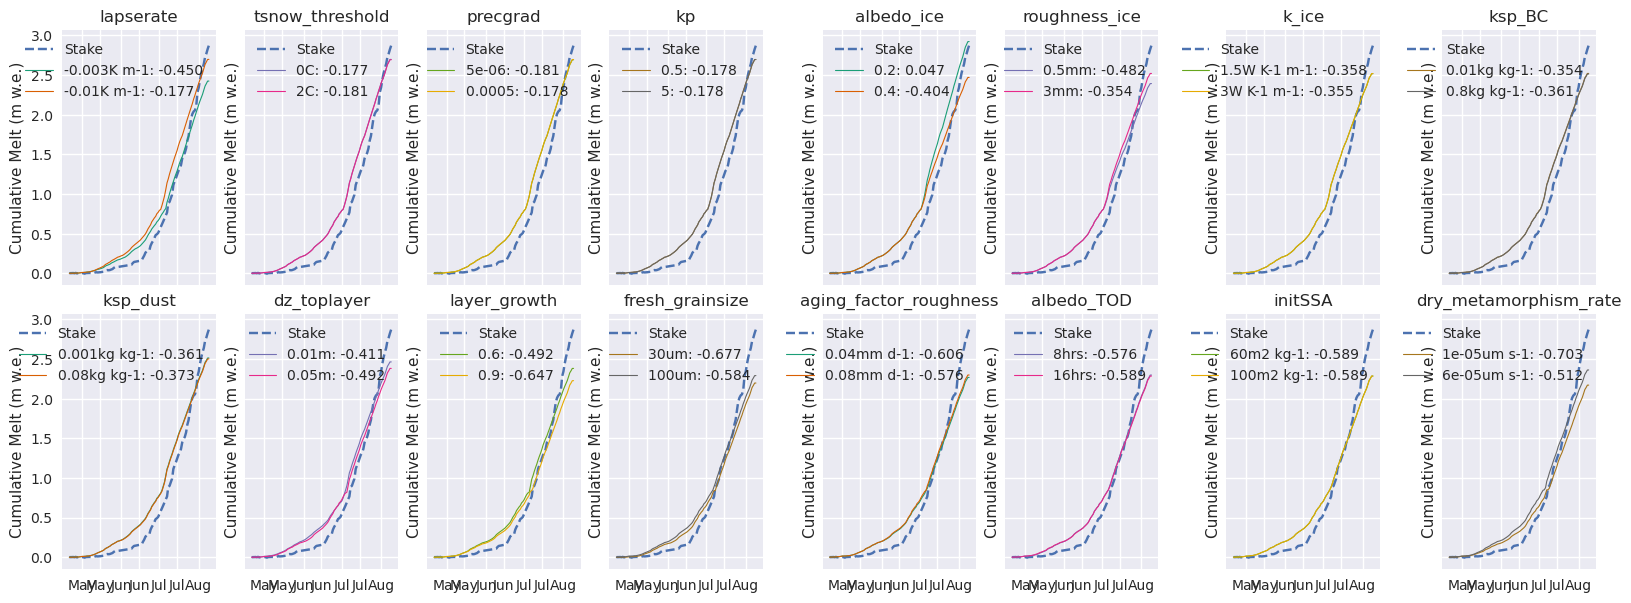

In [20]:
ds_list = list(ds_dict.values())
labels = list(ds_dict.keys())
units = [param_options[label.split('=')[0]]['units'] for label in labels]
panel_MB_compare(ds_list,[startdate,enddate],labels,units,stake_df)

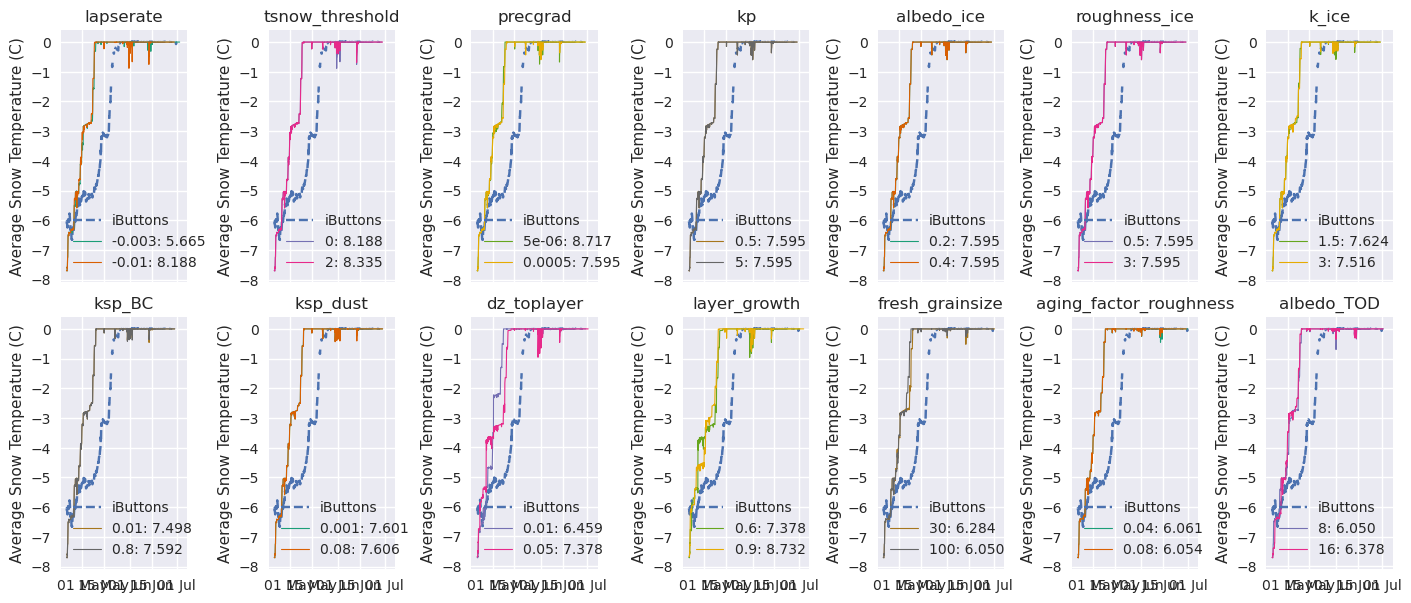

In [50]:
ds_list = list(ds_dict.values())
labels = list(ds_dict.keys())
panel_temp_compare(ds_list,[startdate,enddate],labels,temp_df)

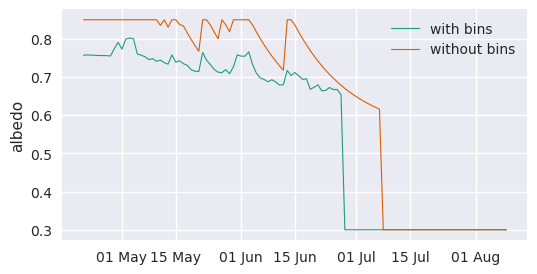

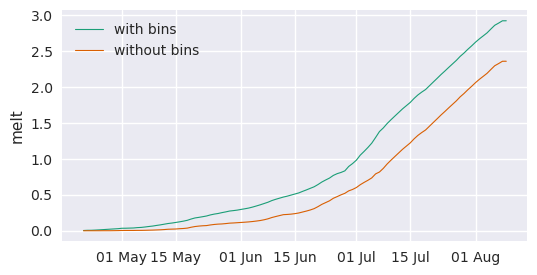

In [117]:
ds_base,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_0.nc')
ds_nolapbins,_,_ = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_noLAPbins.nc')
# ds__,_,_ = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_11_noLAPbins1.nc')
# ds_list = list(ds_dict.values())[0:5]
# labels = list(ds_dict.keys())[0:5]
compare_runs([ds_base,ds_nolapbins],[startdate,enddate],['with bins','without bins'],'albedo')
compare_runs([ds_base,ds_nolapbins],[startdate,enddate],['with bins','without bins'],'melt')

In [5]:
import xarray as xr
xr.open_dataset('~/research/climate_data/MERRA2/QV2M/MERRA2_QV2M_60_-150.nc')

<xarray.Dataset>
Dimensions:  (lat: 20, lon: 16, time: 17544)
Coordinates:
  * lat      (lat) float64 60.0 60.5 61.0 61.5 62.0 ... 67.5 68.0 68.5 69.0 69.5
  * lon      (lon) float64 -150.0 -149.4 -148.8 -148.1 ... -141.9 -141.2 -140.6
  * time     (time) datetime64[ns] 2000-01-01T00:30:00 ... 2022-12-31T23:30:00
Data variables:
    QV2M     (time, lat, lon) float32 ...

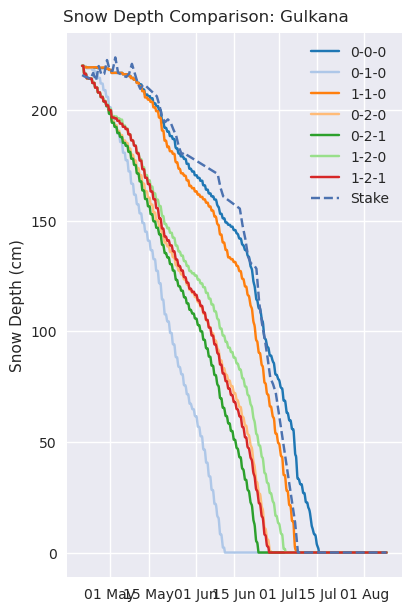

In [28]:
namelabels = ['None','Exp. Degradation','No LAPs, w/ Grain Size','w/ LAPs, No Grain Size','All']
plot_stake_snowdepth(stake_df,[ds0,ds1,ds2,ds3,ds4,ds5,ds6],[startdate,enddate],switch_labels,0,t='Snow Depth Comparison: Gulkana')

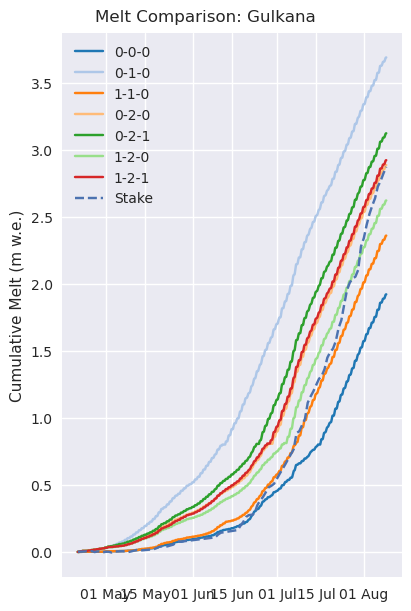

In [30]:
plot_stake_ablation(stake_df,[ds0,ds1,ds2,ds3,ds4,ds5,ds6],[startdate,enddate],switch_labels,0,t='Melt Comparison: Gulkana')

In [17]:
dss = [ds0,ds1,ds2,ds3,ds4]
for i,ds_ in enumerate(dss):
    print('ds',i,'Melt:',ds_.attrs['switch_melt'],'LAPs',ds_.attrs['switch_LAPs'])

ds 0 Melt: 0 LAPs 0
ds 1 Melt: 1 LAPs 0
ds 2 Melt: 2 LAPs 0
ds 3 Melt: 0 LAPs 1
ds 4 Melt: 2 LAPs 1


0 1
0 1


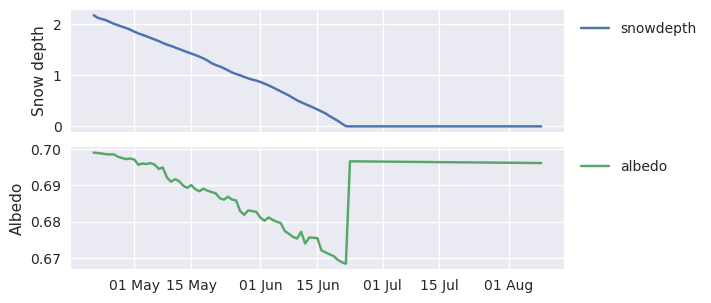

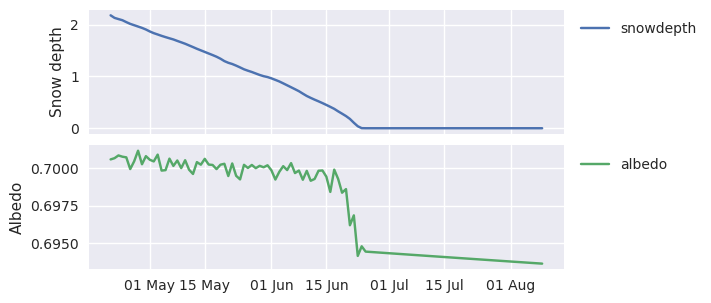

In [25]:
simple_plot(ds,0,[startdate,enddate],
            [['snowdepth'],['albedo']],
            t = '',
            skinny = True,
            new_y='accum',
            save_fig=False)
simple_plot(ds3,0,[startdate,enddate],
            [['snowdepth'],['albedo']],
            t = '',
            skinny = True,
            new_y='accum',
            save_fig=False)
print(ds.attrs['switch_melt'],ds.attrs['switch_LAPs'])
print(ds3.attrs['switch_melt'],ds3.attrs['switch_LAPs'])

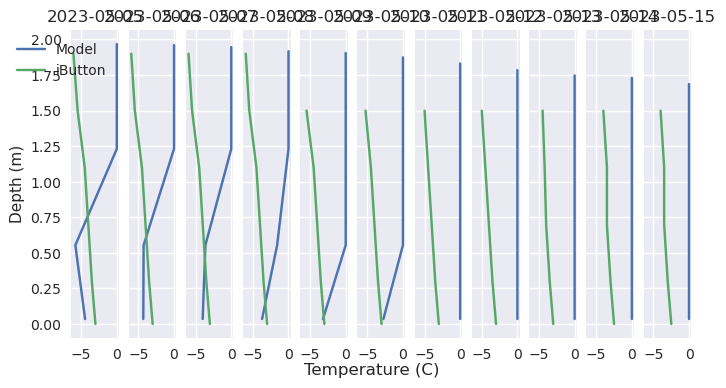

In [29]:
plot_iButtons(list(ds_list)[16],0,pd.date_range('05-05-2023 00:00','05-15-2023 00:00',freq='d'))

In [22]:
snow_height =3.5
dz_toplayer = 0.03
layer_growth = 0.06
lheight = []
ltype = []

current_depth = 0
layer = 0
# Make exponentially growing snow layers
while current_depth < snow_height:
    lheight.append(dz_toplayer * np.exp(layer*layer_growth))
    ltype.append('snow')
    layer += 1
    current_depth = np.sum(lheight)
lheight[-1] = lheight[-1] - (current_depth-snow_height)
print(lheight)

[0.03, 0.03185509639636079, 0.03382490554738127, 0.035916520893654304, 0.03813747450964214, 0.040495764227280094, 0.04299988243681021, 0.04565884666855902, 0.0484822320657868, 0.051480205865545754, 0.054663564011715265, 0.05804377003206094, 0.061632996319316624, 0.06544416796494602, 0.06949100930343274, 0.07378809333470848, 0.07835089420269352, 0.08319584291892893, 0.08834038653196573, 0.09380305095558465, 0.09960350768209641, 0.10576264462096145, 0.11230264131782584, 0.11924704882484244, 0.12662087450989656, 0.13445067211014194, 0.1427646373541356, 0.151592709496916, 0.16096667913365922, 0.17092030268015973, 0.18148942393238837, 0.192712103142874, 0.20462875407872247, 0.21728228955483037, 0.23071827596636996, 0.023332731407806423]


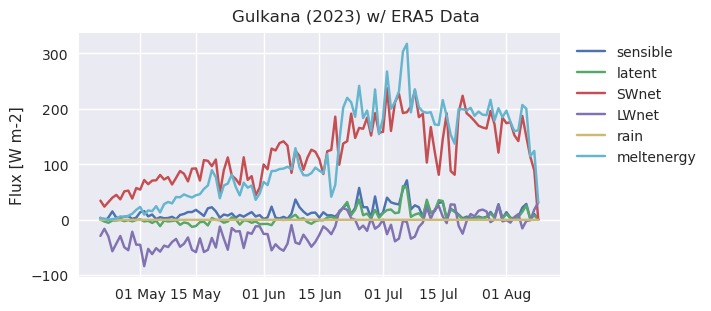

In [67]:
simple_plot(ds,0,[startdate,enddate],[['sensible','latent','SWnet','LWnet','rain','meltenergy']],skinny=False,res='d',t='Gulkana (2023) w/ ERA5 Data')

In [2]:
fp = '/home/claire/research/climate_data/AWS/Raw/on-Glacier/Zongo_surglacier_yrs.xlsx'
yrs = ['0405','0506','0607','0708','0809','0910','1011','1112','1213','1314','1415','1516','1617','1718','1819']
for yr in yrs:
    df = pd.read_excel(fp.replace('yrs',yr))
    if yr in ['0405']:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
print(df_all)

                                                SAMA Unnamed: 1  \
0                            Centrale Campbell CR10X        NaN   
1                    Programme : SAMA1_ORE_ZONGO.CR1        NaN   
2                                 Table : 30 minutes        NaN   
3                                   Glacier du Zongo        NaN   
4      Station météorologique "sur glacier" à 5050 m        NaN   
...                                              ...        ...   
35044                            2019-08-31 22:45:00          0   
35045                            2019-08-31 23:00:00          0   
35046                            2019-08-31 23:15:00          0   
35047                            2019-08-31 23:30:00          0   
35048                            2019-08-31 23:45:00          0   

               Année 2004-2005 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0      GLACIOCLIM (IRD - UMSA)        NaN        NaN        NaN        NaN   
1                          NaN        N